# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [55]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt


%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [56]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'])
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,120.264015,111.911880,122.080002
2017-10-10,120.548782,112.092430,122.400002
2017-10-11,120.714104,112.309067,122.790001
2017-10-12,120.567131,112.787445,122.889999
2017-10-13,120.659012,113.599846,123.820000
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [57]:
weight_df = price_df.copy()
weight_df[:] = [0.6, 0.3, 0.1]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,0.6,0.3,0.1
2017-10-10,0.6,0.3,0.1
2017-10-11,0.6,0.3,0.1
2017-10-12,0.6,0.3,0.1
2017-10-13,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [58]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio      exposure  current_weight  \
datetime   Symbols                                                              
2017-10-09 VTI      120.264015         0.000000      0.000000        0.000000   
           TLT      111.911880         0.000000      0.000000        0.000000   
           GLD      122.080002         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2017-10-10 VTI      120.548782        49.890235   6014.207100        0.601922   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000       672.529612    672.529612        0.050090   
2022-10-07 VTI      182.869995        41.932927   7668.274140        0.581680   
           TLT      101.160004        35.032525   3543.890349        0.268823   
           GLD      158.494995         8.191350   1298.287948        0.098482   
           cash       1.000000       672.529612    672.529612        0.051015   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI       6.000000e-01      0.600000      True           0.600000   
           TLT       3.000000e-01      0.300000      True           0.300000   
           GLD       1.000000e-01      0.100000      True           0.100000   
           cash      1.110223e-16     -1.000000     False           1.000000   
2017-10-10 VTI       6.000000e-01     -0.001922     False           0.601922   
...                           ...           ...       ...                ...   
2022-10-06 cash      1.110223e-16     -0.050090     False           0.050090   
2022-10-07 VTI       6.000000e-01      0.018320     False           0.581680   
           TLT       3.000000e-01      0.031177     False           0.268823   
           GLD       1.000000e-01      0.001518     False           0.098482   
           cash      1.110223e-16     -0.051015     False           0.051015   

                    adj_delta_weight  trade_value  trade_size  end_portfolio  
datetime   Symbols                                                            
2017-10-09 VTI                   0.6       6000.0   49.890235      49.890235  
           TLT                   0.3       3000.0   26.806805      26.806805  
           GLD                   0.1       1000.0    8.191350       8.191350  
           cash                  0.0          0.0    0.000000     -30.000000  
2017-10-10 VTI                   0.0          0.0    0.000000      49.890235  
...                              ...          ...         ...            ...  
2022-10-06 cash                  0.0          0.0    0.000000     672.529612  
2022-10-07 VTI                   0.0          0.0    0.000000      41.932927  
           TLT                   0.0          0.0    0.000000      35.032525  
           GLD                   0.0          0.0    0.000000       8.191350  
           cash                  0.0          0.0    0.000000     672.529612  

[5036 rows x 12 columns]

In [59]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

16

price  start_portfolio     exposure  current_weight  \
datetime   Symbols                                                             
2017-10-09 VTI      120.264015         0.000000     0.000000        0.000000   
           TLT      111.911880         0.000000     0.000000        0.000000   
           GLD      122.080002         0.000000     0.000000        0.000000   
2018-08-07 VTI      137.197159        49.890235  6844.798517        0.640454   
2018-12-20 VTI      117.989220        46.738909  5514.687361        0.556830   
2020-03-09 VTI      132.790421        50.362481  6687.655025        0.542216   
           TLT      164.092438        26.806805  4398.794043        0.356642   
2020-03-23 VTI      107.296585        55.729637  5979.599729        0.559646   
2020-04-08 VTI      131.812042        59.748129  7875.522943        0.645891   
2020-06-04 TLT      151.230606        22.549369  3410.154770        0.258305   
2020-06-05 VTI      155.996826        55.502953  8658.284477        0.648383   
2021-01-05 TLT      151.548309        26.189266  3968.938974        0.259987   
2021-01-06 VTI      190.445480        51.361249  9781.517770        0.642472   
2021-03-12 VTI      202.389786        47.965874  9707.802950        0.640969   
2021-04-27 TLT      134.866821        30.219947  4075.668189        0.258788   
2022-09-12 VTI      205.776382        44.900039  9239.367543        0.642455   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI                0.6      0.600000      True                0.6   
           TLT                0.3      0.300000      True                0.3   
           GLD                0.1      0.100000      True                0.1   
2018-08-07 VTI                0.6     -0.040454      True                0.6   
2018-12-20 VTI                0.6      0.043170      True                0.6   
2020-03-09 VTI                0.6      0.057784      True                0.6   
           TLT                0.3     -0.056642      True                0.3   
2020-03-23 VTI                0.6      0.040354      True                0.6   
2020-04-08 VTI                0.6     -0.045891      True                0.6   
2020-06-04 TLT                0.3      0.041695      True                0.3   
2020-06-05 VTI                0.6     -0.048383      True                0.6   
2021-01-05 TLT                0.3      0.040013      True                0.3   
2021-01-06 VTI                0.6     -0.042472      True                0.6   
2021-03-12 VTI                0.6     -0.040969      True                0.6   
2021-04-27 TLT                0.3      0.041212      True                0.3   
2022-09-12 VTI                0.6     -0.042455      True                0.6   

                    adj_delta_weight  trade_value  trade_size  end_portfolio  
datetime   Symbols                                                            
2017-10-09 VTI              0.600000  6000.000000   49.890235      49.890235  
           TLT              0.300000  3000.000000   26.806805      26.806805  
           GLD              0.100000  1000.000000    8.191350       8.191350  
2018-08-07 VTI             -0.040454  -432.353042   -3.151326      46.738909  
2018-12-20 VTI              0.043170   427.542467    3.623572      50.362481  
2020-03-09 VTI              0.057784   712.706897    5.367156      55.729637  
           TLT             -0.056642  -698.613082   -4.257436      22.549369  
2020-03-23 VTI              0.040354   431.170510    4.018492      59.748129  
2020-04-08 VTI             -0.045891  -559.565386   -4.245177      55.502953  
2020-06-04 TLT              0.041695   550.463789    3.639897      26.189266  
2020-06-05 VTI             -0.048383  -646.092618   -4.141704      51.361249  
2021-01-05 TLT              0.040013   610.842899    4.030681      30.219947  
2021-01-06 VTI             -0.042472 

In [60]:
stats = calc_stats(result)
display(stats)

,portfolio
start,2017-10-09 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,0.318298
cagr,0.056896
max_drawdown,-0.249298
calmar,0.228226
mtd,0.010521
three_month,-0.063174
six_month,-0.174295


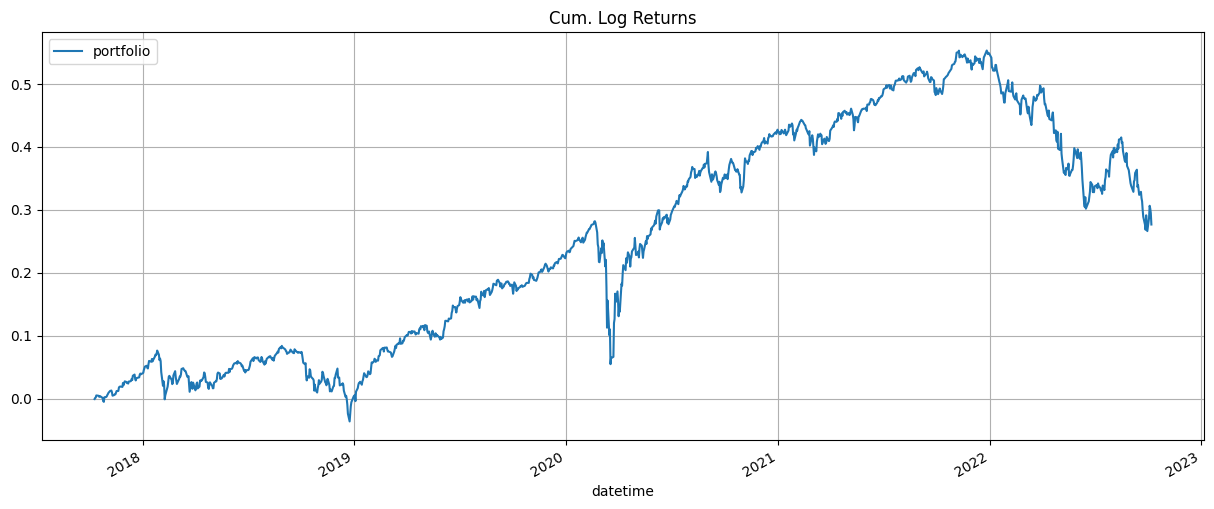

In [61]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

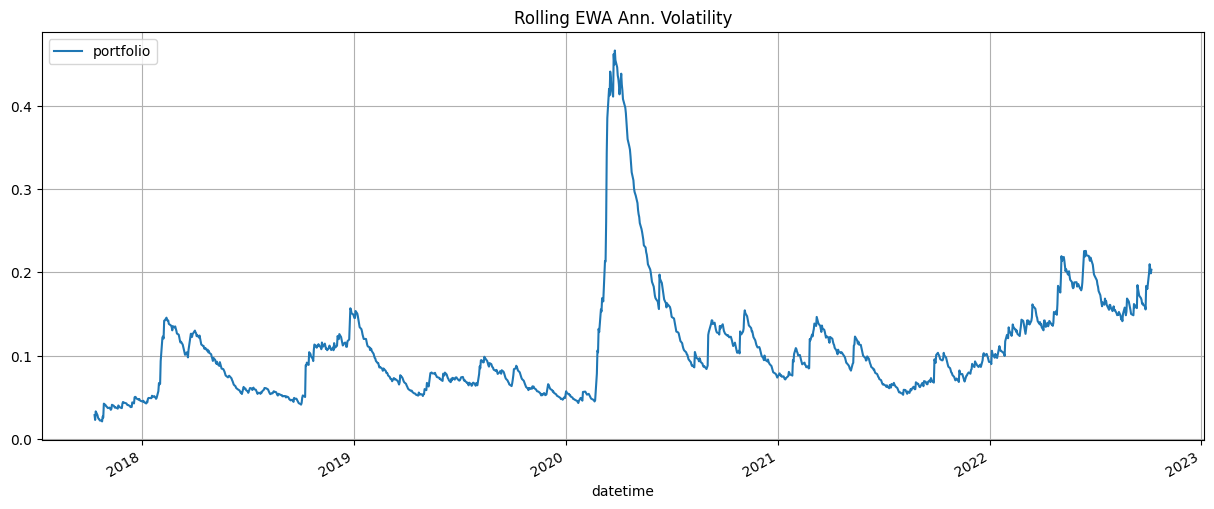

In [62]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()